In [881]:
import pandas as pd
import gmql as gl
import random
# machine learning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.neighbors import DistanceMetric
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from keras import backend as K
import tensorflow as tf
config = tf.ConfigProto(device_count = {'CPU': 1}, intra_op_parallelism_threads=10, inter_op_parallelism_threads=1)
session = tf.Session(config=config)
K.set_session(session)

import numpy as np
import keras as k
# matplotlib properties
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm import tqdm
%matplotlib inline
import keras


from keras import applications
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.layers import Input


#get_ipython().run_line_magic('matplotlib', 'inline')
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
matplotlib.rcParams['font.size'] = 22
matplotlib.rcParams['xtick.labelsize'] = 22
matplotlib.rcParams['ytick.labelsize'] = 22
matplotlib.rcParams['axes.labelsize'] = 30
matplotlib.rcParams['axes.titlesize'] = 30

In [882]:
def load_corr_mat():
    result = pd.read_csv('corr_m_full.csv',header = None).as_matrix()
    return result

def CorrelationMatrix(X):
    corr_matrix = np.corrcoef(X.astype(float), rowvar = False)
    cm_df = pd.DataFrame(corr_matrix)
    cm_df.to_csv('corr_m.csv',index = None,header = None)
    return corr_matrix


def save_masks_and_scores(masks,scores):
    masks_pd = pd.DataFrame(masks)
    masks_pd.to_csv('masks_full_500.csv',header = None,index = None)
    scores_pd = pd.DataFrame(scores)
    scores_pd.to_csv('scores_full_500.csv',header = None,index = None)
    return

def run_classifier(X,Y):
    classy = DecisionTreeClassifier(min_samples_split = 10, min_samples_leaf = 5, random_state = 1)
    #classy = KNeighborsClassifier(n_neighbors=3, weights='uniform', n_jobs = 10, metric = 'chebyshev')
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)
    classy = classy.fit(X_train,Y_train)
    Y_pred = classy.predict(X_test)
    score = f1_score(Y_test, Y_pred, average = 'macro')
    importance = classy.feature_importances_
    return score, importance

def write_to_file(score, rank, index, subset_size, num_iters,k_top,tads = True):
    if tads == True:
        f_handle = open('scores_chosen_'+str(k_top)+'_from_tads_'+str(subset_size)+'__'+str(num_iters)+'.dat', 'ab')
        np.savetxt(f_handle, np.array([score]), fmt = '%.5f', delimiter=',')
        f_handle.close()

        f_handle = open('indexes_chosen_'+str(k_top)+'_from_tads_'+str(subset_size)+'__'+str(num_iters)+'.dat', 'ab')
        np.savetxt(f_handle, index, fmt = '%i', delimiter=',')
        f_handle.close()

        f_handle = open('ranks_chosen_'+str(k_top)+'_from_tads_'+str(subset_size)+'__'+str(num_iters)+'.dat', 'ab')
        np.savetxt(f_handle, rank, fmt = '%.5f', delimiter=',')
        f_handle.close()

    else:
        f_handle = open('scores_chosen_'+str(k_top)+'_full_'+str(subset_size)+'__'+str(num_iters)+'.dat', 'ab')
        np.savetxt(f_handle, np.array([score]), fmt = '%.5f', delimiter=',')
        f_handle.close()

        f_handle = open('indexes_chosen_'+str(k_top)+'_full_'+str(subset_size)+'__'+str(num_iters)+'.dat', 'ab')
        np.savetxt(f_handle, index, fmt = '%i', delimiter=',')
        f_handle.close()

        f_handle = open('ranks_chosen_'+str(k_top)+'_full_'+str(subset_size)+'__'+str(num_iters)+'.dat', 'ab')
        np.savetxt(f_handle, rank, fmt = '%.5f', delimiter=',')
        f_handle.close()
 

    
def apply_mask_to_X(mask,tcga_X):
    result = np.zeros((tcga_X.shape[0],tcga_X.shape[1]),float)
    for j in range(0,tcga_X.shape[0]):
        X_new = np.multiply(tcga_X[j,:], mask)
        result[j,:] = X_new
    return result

def index_generator(index_num, list_of_gene_indx):
    random.shuffle(list_of_gene_indx)
    res = list(list_of_gene_indx[:index_num])
    return res

def generate_mask(mean,devi,length):     
    mask = np.random.normal(loc = mean,scale = devi, size=length)
    mask = abs(mask)
    np.random.shuffle(mask)
    return mask

def init_files(num_iters,subset_size,k_top,tads = True):
    if tads == True:
        f_handle = open('scores_chosen_'+str(k_top)+'_from_tads_'+str(subset_size)+'__'+str(num_iters)+'.dat', 'w')
        f_handle.close()
        f_handle = open('indexes_chosen_'+str(k_top)+'_from_tads_'+str(subset_size)+'__'+str(num_iters)+'.dat', 'w')
        f_handle.close()
        f_handle = open('ranks_chosen_'+str(k_top)+'_from_tads_'+str(subset_size)+'__'+str(num_iters)+'.dat', 'w')
        f_handle.close()
    else:
        f_handle = open('scores_chosen_'+str(k_top)+'_full_'+str(subset_size)+'__'+str(num_iters)+'.dat', 'w')
        f_handle.close()
        f_handle = open('indexes_chosen_'+str(k_top)+'_full_'+str(subset_size)+'__'+str(num_iters)+'.dat', 'w')
        f_handle.close()
        f_handle = open('ranks_chosen_'+str(k_top)+'_full_'+str(subset_size)+'__'+str(num_iters)+'.dat', 'w')
        f_handle.close()        
    
def cluster_generator_wrapper_subsets(tcga_X,tcga_Y,num_iters,subset_size,k_top, tads = True):
    list_of_genes = list(range(0,tcga_X.shape[1]))
    
    init_files(num_iters,subset_size,k_top,tads)
    
    step = subset_size
    it = 0
    while(len(list_of_genes)>=step):
        it += 1
        #print(it,len(list_of_genes))
        scores = np.zeros(num_iters,float)
        importance = np.zeros((num_iters,subset_size),float)
        subset_inds = np.zeros((num_iters,subset_size),int)
        for i in range(0,num_iters):
            subset_inds[i,:] = index_generator(subset_size, list_of_genes)
            masked_X = tcga_X[:,subset_inds[i,:]]
            scores[i], importance[i,:] = run_classifier(masked_X,tcga_Y)
        sorted_scores_inds = np.argsort(subset_inds,axis = 1)
        sorted_scores = np.argsort(scores)
        write_to_file(scores[sorted_scores[-1]], importance[sorted_scores[-1],:], 
                      subset_inds[sorted_scores[-1],:], subset_size, num_iters,k_top)   
        list_of_genes = list(set(list_of_genes)-set(list(subset_inds[sorted_scores[-1],:])))
    if (len(list_of_genes) == 0):
        return
    masked_X = tcga_X[:,list_of_genes]
    score_rest, importance_rest = run_classifier(masked_X,tcga_Y)
    write_to_file(score_rest, importance_rest, list_of_genes,subset_size, num_iters,k_top)
    return

# def cluster_generator_wrapper_masks(tcga_X,tcga_Y,num_iters,subset_size):
#     list_of_genes = list(range(0,tcga_X.shape[1]))
#     step = subset_size
#     while(len(list_of_genes)>step):
#         masks = np.zeros((num_masks,len(list_of_genes)),float)
#         scores = np.zeros(masks.shape[0],float)
#         for i in range(0,num_masks):
#             masks[i,:] = generate_mask(0,0.00001,len(list_of_genes))
#             masked_X = apply_mask_to_X(masks[i,:],tcga_X[:,list_of_genes])
#             scores[i],_ = run_classifier(masked_X,tcga_Y)
#             sorted_masks_inds = np.argsort(masks[i,:])
#             write_to_file(scores[i], len(list_of_genes), sorted_masks_inds[-step:],current=True)
#         sorted_masks_inds = np.argsort(masks,axis = 1)
#         sorted_scores = np.argsort(scores)
#         write_to_file(666, 666, sorted_masks_inds[sorted_scores[-1],-step:],current=False)
#         list_of_genes = list(set(list_of_genes)-set(sorted_masks_inds[sorted_scores[-1],-step:]))
#     write_to_file(666, 666, list_of_genes,current=False)
#     return
        
        
def threshold_masks(masks, threshold):
    masks[masks<threshold] = 0
    return masks

def get_raw_data(tcga_path, kop_k, tads = True):
    #tcga_path = "/home/nanni/Data/TCGA/all_tcga.tsv"
    tcga = pd.read_csv(tcga_path, sep="\t", header=[0,1,2], index_col=0)
    patients = tcga.T.reset_index()
    patients = patients.rename(columns={'level_0': 'tissue', 
                                        'level_1': 'type', 
                                        'level_2': 'patient_id'})
    patients.index.name = "patient"
    gene_names = tcga.index.tolist()
    pat_tissue = np.array(patients.values[:,0],str)
    pat_tissue = patients.values[:,0] 
    tcga_X,tcga_Y = GenerateXY(patients,pat_tissue)
    
    gene_selector = SelectKBest(score_func=chi2, k=kop_k)
    X_train, X_test, Y_train, Y_test = train_test_split(tcga_X, tcga_Y, test_size=0.33, random_state=42)
    X_train = gene_selector.fit_transform(X_train,Y_train)
    X_test = gene_selector.transform(X_test)
    
    
    scores_chi2 = gene_selector.scores_
    if (scores_chi2[0]>scores_chi2[-1]):
        top_inds_to_use = np.argsort(scores_chi2)[:kop_k] 
    else:
        top_inds_to_use = np.argsort(scores_chi2)[-kop_k:]
    np.save('chi2_chosen_genes', top_inds_to_use)
    
    
    return X_train,X_test,Y_train,Y_test



def GenerateXY(patients,pat_tissue):

    tcga_X = np.array(patients[patients.type == 'cancer'].values[:,3:],float)
    tcga_X = patients[patients.type == 'cancer'].values[:,3:]

    tcga_Y = np.zeros(len(tcga_X),int)
    list_of_tissues = ['BLCA','BRCA','COAD','HNSC','KICH','KIRC','KIRP','LIHC','LUAD','LUSC','PRAD','THCA','UCEC']
    for i in range(0,len(patients[patients.type == 'cancer'])):
        for j in range(0,len(list_of_tissues)):
            if pat_tissue[i] == list_of_tissues[j]:
                tcga_Y[i] = j

    return tcga_X,tcga_Y

def splitter(X,Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
    X_train, X_cv,Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.33, random_state=42)
    return X_train, X_cv, X_test, Y_train, Y_cv, Y_test

def replace(fname, textToSearch, textToReplace):
    import fileinput
    with fileinput.FileInput(fname, inplace=True, backup='.bak') as file:
        for line in file:
            line.replace(textToSearch, textToReplace)
def subset_scores_load(num_iters, subset_size,k_top):

    scores = []
    inds = []
    i_t = []
    ranks = []
    r_t = []
    ite = 0
    
    fname = 'scores_chosen_'+str(k_top)+'_from_tads_'+str(subset_size)+'__'+str(num_iters)+'.dat'
    reader = open(fname,'r')
    for row in reader:
        row = row.replace('\n','') 
        scores.append(float(row))
      
    
    fname = 'ranks_chosen_'+str(k_top)+'_from_tads_'+str(subset_size)+'__'+str(num_iters)+'.dat'
    reader = open(fname,'r')
    for row in reader:
        row = row.replace('\n','') 
        if ite < subset_size:           
            r_t.append(float(row))
            ite+=1
        else:       
            ranks.append(r_t)
            r_t = []
            r_t.append(float(row))
            ite = 1
    if(len(scores)>len(inds)):
            ranks.append(r_t)
    
    ite = 0        
    
    fname = 'indexes_chosen_'+str(k_top)+'_from_tads_'+str(subset_size)+'__'+str(num_iters)+'.dat'  
    reader = open(fname,'r')
    for row in reader:
        row = row.replace('\n','') 
        if ite < subset_size:
            i_t.append(int(row))
            ite+=1
        else:
            inds.append(i_t)
            i_t = []
            i_t.append(int(row))
            ite = 1                
    if(len(scores)>len(inds)):
        inds.append(i_t)
    return scores, ranks, inds

def get_distance_matrix(scores,indexes,ranks,num_feats):
    dist_inner = np.zeros((num_feats,num_feats),float)
    dist_clust = np.zeros((num_feats,num_feats),float)
    dist_final = np.zeros((num_feats,num_feats),float)
    for i in range(0,len(scores)):
        for j in range(0,len(scores)):
            dist = abs(scores[i]-scores[j])
            for feat1 in range(0,len(indexes[i])):
                for feat2 in range(0,len(indexes[j])):
                    dist_clust[indexes[i][feat1],indexes[j][feat2]] = dist
    for i in range(0,len(scores)):
            for feat1 in range(0,len(indexes[i])):
                for feat2 in range(0,len(indexes[i])):
                    dist = abs(ranks[i][feat1]-ranks[i][feat2])
                    if dist == 0.0 and i != j:
                        dist = 1e-7
                    if i==j:
                        dist = 1e-9
                    dist_inner[indexes[i][feat1],indexes[i][feat2]] = dist
    
    dist_inner[dist_inner == 0] = np.max(dist_inner)*2.0
    dist_inner[dist_inner == 1e-9] = 0
    dist_final = dist_inner + dist_clust
    return dist_final

    

In [883]:
num_features = False
num_iters = 100
subset_size = 100
top_k = 2000
tads = False

In [849]:
if tads == True:
    path = "/home/nanni/Projects/ML/TAD_Trento/all_tcga_only_TADs.tsv"
else:
    path = "/home/nanni/Data/TCGA/all_tcga.tsv"

X_train,X_test,Y_train,Y_test = get_raw_data(path, top_k, tads)

In [884]:
cluster_generator_wrapper_subsets(X_train, Y_train, num_iters, subset_size,top_k)
scores, ranks, inds = subset_scores_load(num_iters, subset_size, top_k)
dist_final = get_distance_matrix(scores,inds,ranks,top_k)

In [885]:
print(np.shape(dist_final))

(2000, 2000)


In [886]:
np.save('./distance matrices/distance_mat_'+str(num_iters)+'iter_'+str(num_features)+'_feats_'+str(subset_size)+'feats_subset_ALL', dist_final)
lol = np.load('./distance matrices/distance_mat_100iter_False_feats_100feats_subset_ALL.npy')
pds = pd.DataFrame(lol)
pds.to_csv('./distance matrices/distance_mat_100iter_False_feats_100feats_subset_ALL.csv',index = None, header = None)

In [898]:
pearson = np.corrcoef(X_train,rowvar=False)

In [899]:
pearson = np.nan_to_num(pearson)
pearson = abs(pearson)
pearson[pearson < 1e-7] = 1e-7
pears = 1-pearson

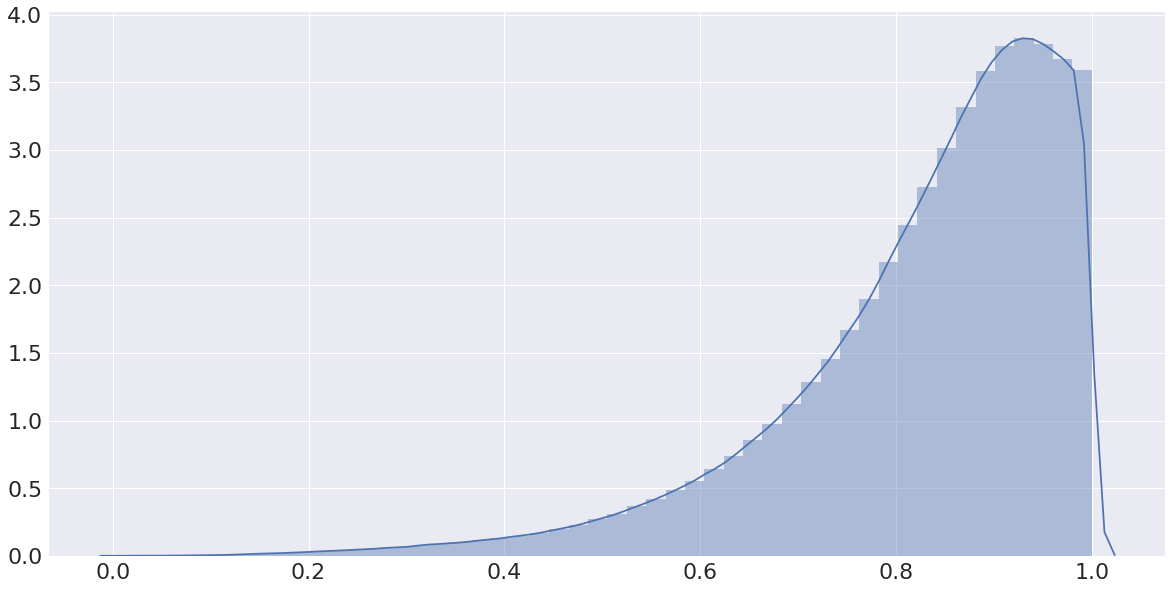

In [864]:
# sns.heatmap(pears)
# plt.show()

sns.distplot(pears[np.triu_indices_from(pears, k=1)])

In [852]:
p_df = pd.DataFrame(pears)
p_df.to_csv('dist_matrix_correl_ALL.csv',header = None, index = None)

In [754]:
df_df = pd.DataFrame(dist_final)
df_df.to_csv('for_R.csv',header = None,index = None)

In [841]:
np.shape(X_train)

(4200, 2000)

In [904]:
trans = MDS(n_components=40000, metric=True, n_init=1, max_iter=3500, verbose=5, eps=0.001, n_jobs=1, 
        random_state=42, dissimilarity='precomputed')
MDSres = trans.fit_transform(pears)


it: 0, stress 13056327638.6
it: 1, stress 33968.4100506
it: 2, stress 32240.5163386
it: 3, stress 31719.6047653
it: 4, stress 31531.1203016
it: 5, stress 31437.2217245
it: 6, stress 31369.7496261
it: 7, stress 31307.5028794
it: 8, stress 31243.081847
it: 9, stress 31173.4017043
it: 10, stress 31096.7796584
it: 11, stress 31011.9740283
it: 12, stress 30917.8448799
it: 13, stress 30813.2263107
it: 14, stress 30696.8758421
it: 15, stress 30567.454517
it: 16, stress 30423.5213604
it: 17, stress 30263.5367381
it: 18, stress 30085.8733137
it: 19, stress 29888.8349822
it: 20, stress 29670.6848195
it: 21, stress 29429.6832488
it: 22, stress 29164.1374463
it: 23, stress 28872.4625087
it: 24, stress 28553.2540673
it: 25, stress 28205.3708542
it: 26, stress 27828.0242266
it: 27, stress 27420.8699533
it: 28, stress 26984.0958481
it: 29, stress 26518.4973984
it: 30, stress 26025.5327247
it: 31, stress 25507.3483778
it: 32, stress 24966.768897
it: 33, stress 24407.2457833
it: 34, stress 23832.765387

it: 278, stress 4464.82125364
it: 279, stress 4460.85998404
it: 280, stress 4456.93927359
it: 281, stress 4453.05861083
it: 282, stress 4449.21749204
it: 283, stress 4445.41542113
it: 284, stress 4441.6519094
it: 285, stress 4437.92647548
it: 286, stress 4434.23864513
it: 287, stress 4430.58795111
it: 288, stress 4426.97393308
it: 289, stress 4423.39613741
it: 290, stress 4419.8541171
it: 291, stress 4416.34743164
it: 292, stress 4412.87564689
it: 293, stress 4409.43833497
it: 294, stress 4406.03507412
it: 295, stress 4402.66544863
it: 296, stress 4399.3290487
it: 297, stress 4396.02547037
it: 298, stress 4392.75431535
it: 299, stress 4389.51519103
it: 300, stress 4386.30771026
it: 301, stress 4383.13149136
it: 302, stress 4379.98615797
it: 303, stress 4376.87133896
it: 304, stress 4373.78666839
it: 305, stress 4370.73178535
it: 306, stress 4367.70633397
it: 307, stress 4364.70996324
it: 308, stress 4361.74232701
it: 309, stress 4358.80308386
it: 310, stress 4355.89189707
it: 311, stre

In [756]:
np.save('2000_feats_5_in_subset_1iter_TADs_MDS_8k_dim', MDSres)

In [572]:
print(np.shape(MDSres))

(1000, 40)


In [906]:
pathh = './distance matrices/'
name = 'distance_mat_1iter_False_feats_5feats_subset_TADs'
#dist_final = np.load(pathh+name+'.npy')
dist_final = pd.read_csv(pathh+name+'.csv', header = None).as_matrix()
R_mds = pd.read_csv(pathh+'MDSes/'+name+'_MDS.csv',index_col= 0).as_matrix()

In [907]:
def get_interclust_dists(MDSres):
    dist_m = np.zeros((MDSres.shape[1],MDSres.shape[1]),float)
    for i in range(0,MDSres.shape[1]):
        for j in range(i + 1,MDSres.shape[1]):
            distIJ = np.sqrt(np.sum((MDSres[:,i]-MDSres[:,j])**2))
            dist_m[i,j] = distIJ
            dist_m[j,i] = distIJ
    return dist_m

def get_k_nearest_inds(dist_m,i,k):
    all_dists = np.argsort(dist_m[i,:])
    return all_dists[:k]

def check_preservation_of_dims(MDSres, dist_input):
    k = 4
    preserved = 0.0
    distroyed = 0.0
    print("Computing distances in MDSres")
    dist_m = get_interclust_dists(MDSres)
    print("Finding nearest neighbors")
    for i in range(0, dist_input.shape[1]):
        k_input = get_k_nearest_inds(dist_input,i,k)
        k_trans = get_k_nearest_inds(dist_m,i,k)
        if set(k_trans) == set(k_input):
            preserved += 1.0
        else:
            distroyed += 1.0        
    #print(preserved/(preserved+distroyed))
    return preserved/(preserved+distroyed)
    
check_preservation_of_dims(R_mds.T, dist_final)

Computing distances in MDSres
Finding nearest neighbors


0.998

In [ ]:
num_of_steps = 50
step = 100
res = np.zeros(num_of_steps,float)
def MDS_analysis(num_of_dims):
    trans = MDS(n_components=num_of_dims, metric=True, n_init=5, max_iter=1500, verbose=0, eps=0.001, n_jobs=10, 
            random_state=42, dissimilarity='precomputed')
    MDSres = trans.fit_transform(dist_final)
    return check_preservation_of_dims(MDSres.T, dist_input)

for i in range(0,num_of_steps):
    num_of_dims = i * step + 3
    res[i] = MDS_analysis(num_of_dims)
    print("{}\t{}\t{}".format(i, num_of_dims, res[i]))

np.save('MDS_analysis',res)

In [661]:
result = np.load('MDS_analysis.npy')

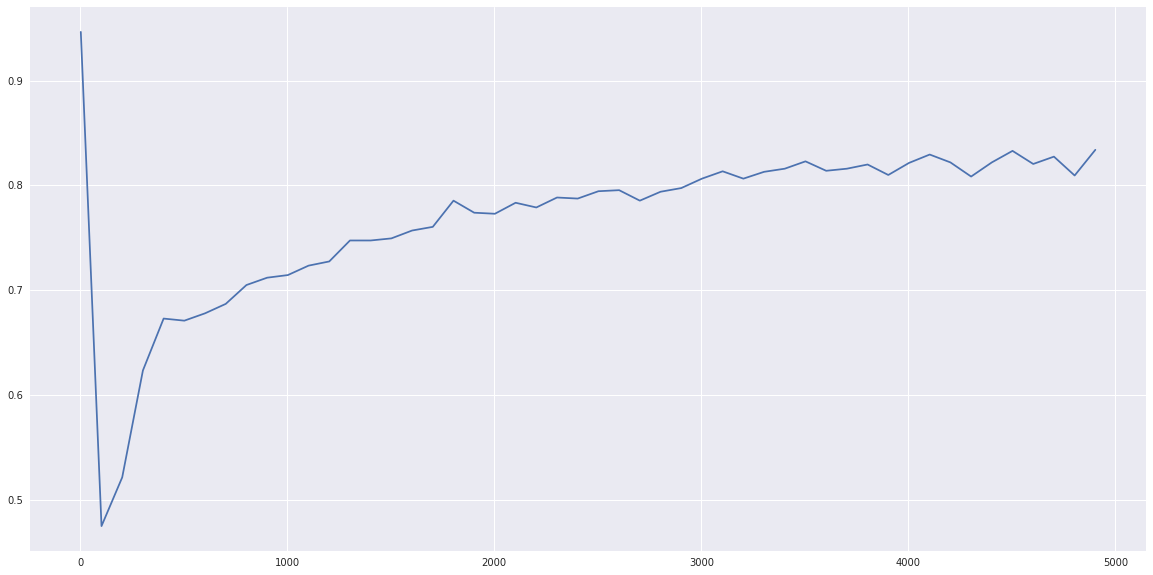

In [663]:
i = range(3,5003,100)
plt.plot(i,result)
plt.show()